## Business Problem

Company Xero is a worldwide e-commerce site with localized versions of the site. We noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.We hypothesized that one reason could be translation. All Spanish speaking
countries had the same translation of the site which was written by a Spaniard. We agreed to try a test where each country would have its one translation written by a local. That is,Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.

Here, we made a hypothsis that the local translation treatment will increase the conversion rate.

In this task, I am going to analyze whether the effect of localized-translation is working and interpret the results based on the analysis.

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
%matplotlib inline

In [51]:
import scipy.stats as ss
from scipy.stats import norm

## Join the two tables

In [4]:
# load in the data
user=pd.read_csv("E:/DataArtist/THC/ABtest/user_table.csv")
test=pd.read_csv("E:/DataArtist/THC/ABtest/test_table.csv")

In [10]:
user.head(10)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain
5,62371,M,29,Ecuador
6,987967,M,31,Spain
7,499510,F,29,Paraguay
8,364726,F,29,Colombia
9,572551,M,21,Bolivia


In [15]:
# check duplicate value
len(user['user_id'].unique())==len(user['user_id'])

True

No duplicate user_id the user data set.

In [20]:
# check if data in the user table is also in the test table
len(user['user_id'])-len(test['user_id'])

-454

In [23]:
# check if there is missing value
user.isnull().any()
test.isnull().any()

user_id             False
date                False
source              False
device              False
browser_language    False
ads_channel          True
browser             False
conversion          False
test                False
dtype: bool

The main purpose of this project is to do t-test on the different groups, we will not cancel the users where ads_channel has null values, that will make us lose a lot of data

In [25]:
# Since we have noticed that user_id is test table is far larger than the user_id in test table
# We will use the test left join user to make sure that all the user_ids are contained
data=test.merge(user,how='left')

In [29]:
obj=pd.Series(range(3),index=['a','b','c'])

In [27]:
# check the summary statistics of the data
data.describe(include="all")

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000,452867,452867.000000,452867
unique,NaN,5,3,2,3,5,7,NaN,NaN,2,NaN,17
top,NaN,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN,M,NaN,Mexico
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN,264485,NaN,128484
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446,NaN,27.130740,NaN
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445,NaN,6.776678,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,18.000000,NaN
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,22.000000,NaN
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,26.000000,NaN
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,31.000000,NaN


## Conduct a t-test on the train group and test group

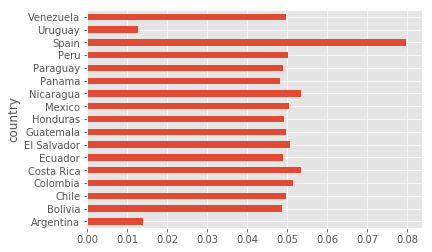

In [69]:
# Check whether the conversion rate in spain(non-localization translation) is better than other Lational Countries(localization translation)
# We group the data by country and calculate the mean of the conversion rate
a=data.groupby('country',sort=True)['conversion'].mean()
a.sort_values()
a.plot(kind="barh")

From the ranking, I can find that it's true that the Spain has the highest conversion rate comparing with other Latin American Countries. I will further do the t-test to check whether this difference is statistically significant.

In [50]:
# Decide the comparing groups
# Since our treatment changed nothing in Spain users, so we will exclude the Spain users
data_no_spain=data.loc[data['country']!='Spain',:]
data_no_spain.groupby("test")[['conversion']].mean()
ss.ttest_ind()

,conversion
test,
0,0.048330
1,0.043425


In [54]:
conv_in_test = data_no_spain.loc[data_no_spain['test']==1,"conversion"]
conv_in_control=data_no_spain.loc[data_no_spain['test']==0,"conversion"]
ss.ttest_ind(conv_in_test,conv_in_control)

Ttest_indResult(statistic=-7.4225120959547688, pvalue=1.15144687852198e-13)

Contradictory to our original hypothesis, the local translation feature doesn't increase the conversion rate. 
The conversion rate in test group is significantly lower than the conversion rate in the control group.

## Find out reason why the test effect is not significant

Here, I make some hypothesis on why the test doesn't work:
+ The data is not large enough and the time frame we conduct the experiemnt is too short. From the above analysis, we can find that the time window is less than a week.
+ Some confounding variables might exist. We will further explore what's the confounding variables

I first plot the test-control difference day by day to see the time series pattern.

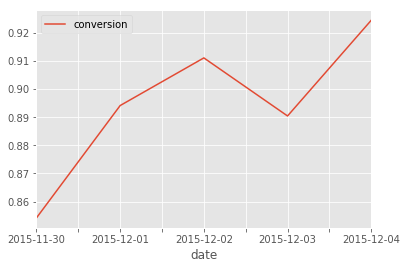

In [64]:
data_no_spain_test=data_no_spain.loc[data_no_spain['test']==1,:]
data_no_spain_control=data_no_spain.loc[data_no_spain['test']==0,:]
b=data_no_spain_test.groupby("date")[['conversion']].mean()/data_no_spain_control.groupby("date")[['conversion']].mean()
b.plot()

I can find that the conversion rate in the test group is always lower than the conversion rate in the control group.I need to run the AB test at least one week to capture the weekly patterns.

I will now check whether the cofounding variables exist. In this case, I will check when I control the country is the difference still statistically signifcant.Theortically speaking the distribution of the people in the test and control group should be exaclty the same.

In [168]:
# get the name of the country
c=data_no_spain['country'].unique()
# cancel the nan value
c=c[:-1]
# initiate a list to store the p value and t statistics
t_test_results = {}
for i in c:
    d=data_no_spain.loc[data_no_spain['country']==i,:]
    d_test=d.loc[d['test']==1,"conversion"]
    d_control=d.loc[d['test']==0,"conversion"]
    t_test_results[i] = ss.ttest_ind(d_test,d_control)
results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df.columns = ['statistic','pvalue']
results_df

,statistic,pvalue
Mexico,1.386662,0.165547
Venezuela,-0.562558,0.573740
Bolivia,-0.359969,0.718877
Colombia,-0.799968,0.423733
Uruguay,0.147414,0.882812
El Salvador,-1.154691,0.248251
Nicaragua,0.278873,0.780351
Peru,0.289828,0.771950
Costa Rica,0.401779,0.687863
Chile,1.030324,0.302871


None of the effect is significant when we control the varibale country.

## Conclusion

The attempt of localization translation doesn't increase the conversion rate, but after we control the confounding variable country, at least we can draw the conclusion that the new feature doesn't make things worse.